# BPM ESTIMATION ON REAL VIDEO 

Explanation of the script for testing on real data in the same condition as pyVHR

## Import librairies

Previously , you have to install theses python librairies :
* tensorflow (2.2.0)
* matplotlib
* scipy
* numpy
* opencv-python
* Copy
* pyVHR (0.0.1)

In [ ]:
##
## Importing libraries
##

#Tensorflow/KERAS
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.utils import np_utils

# Numpy / Matplotlib / OpenCV / Scipy / Copy / ConfigParser
import numpy as np
import scipy.io
import scipy.stats as sp
import matplotlib.pyplot as plt
import cv2
from copy import copy
import os
import configparser

#pyVHR
from pyVHR.signals.video import Video
from pyVHR.datasets.dataset import Dataset
from pyVHR.datasets.dataset import datasetFactory

## Load configuration (BPMEstimationOnRealVideo.cfg) 

In [ ]:
##
## Loading configuration
##

config = configparser.ConfigParser()

config.read('./BPMEstimationOnRealVideo.cfg')

if(int(config['ExeConfig']['useCPU']) == 1):
    #RUN ON CPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Load the video & pyVHR processing

In the pyVHR framework, we work on a processed video. The processing consists of detecting and extracting an area of interest, in order to apply our rPPGs methods on relevant data.

* videoFilename : path of the video
* return : video processed

In [ ]:
##
## Loading the video & pyVHR processing
##

def extraction_roi(video_filename):
    video = Video(video_filename)
    video.getCroppedFaces(detector='dlib', extractor='skvideo')
    video.setMask(typeROI='skin_adapt',skinThresh_adapt=0.30)
    return video

## Load the model

Load model & classes

* model_path : path of the model
* return :
    * model : the model trained to make predictions
    * freq_BPM : array containing the set of classes (representing each bpm) known by the model


In [ ]:
##
## Loading the model
##

def loadmodel(model_path):
    model = model_from_json(open(f'{model_path}/model_conv3D.json').read())
    model.load_weights(f'{model_path}/weights_conv3D.h5')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # define the frequencies // output dimension (number of classes used during training)
    freq_bpm = np.linspace(55, 240, num=model.output_shape[1]-1)
    freq_bpm = np.append(freq_bpm, -1)     # noise class
    return model, freq_bpm

## Convert videoframes to a single channel array

Select one channel for making prediction

* video : whole video
* model : the model trained to make predictions
* startFrame : first frame to be read
* return : frames normalized


In [ ]:
##
## Converting videoframes to a single channel array
##

def convert_video_to_table(video,model, start_frame):
    imgs = np.zeros(shape=(model.input_shape[1], video.cropSize[0], video.cropSize[1], 1))

    # channel extraction
    if (video.cropSize[2]<3):
        IMAGE_CHANNELS = 1
    else:
        IMAGE_CHANNELS = video.cropSize[2]

    # load images (imgs contains the whole video)
    for j in range(0, model.input_shape[1]):

        if (IMAGE_CHANNELS==3):
            temp = video.faces[j + start_frame]/255
            temp = temp[:,:,1]      # only the G component is currently used
        else:
            temp = video.faces[j + start_frame] / 255

        imgs[j] = np.expand_dims(temp, 2)
    return imgs

## Get a prediction

Using the model to make a prediction on a map tile

* model : the model trained to make predictions
* freq_bpm : array containing the set of classes (representing each bpm) known by the model
* xtest : model input
* return : A prediction

In [1]:
##
## Using the model to make a prediction on a map tile
##

def get_prediction(model,freq_bpm, xtest):
    idx = 0
    # model.predict
    input_tensor = tf.convert_to_tensor(np.expand_dims(xtest, 0))
    h = model(input_tensor)
    h = h.numpy() 
    #Binary prediction
    res = np.zeros(shape=(76))
    idx = get_idx(h[0])
    res[idx] = 1
    return res


## Format Video

Realization of a catagraphy of predictions on the video. This function formats the video in several sets of tests, in order to make multiple predictions. The sum of these predictions is returned.

* video : whole video
* model : the model trained to make predictions
* imgs : Video sequence submitted to the prediction (including the subject's face)
* freq_BPM : array containing the set of classes (representing each bpm) known by the model
* stepX : horizontal step for mapping
* stepY : vertical step for mapping

In [ ]:
##
## Formating Video
##

def formating_data_test(video, model, imgs , freq_bpm, step_x, step_y):
    
    # output - sum of predictions
    predictions = np.zeros(shape=(len(freq_bpm)))
    
    # Displacement on the x axis
    iteration_x = 0
    # Our position at n + 1 on the X axis
    axis_x = model.input_shape[3]
    
    # width of video
    width = video.cropSize[1]
    # height of video
    height = video.cropSize[0]
    
    # Browse the X axis
    while axis_x < width:
        # Displacement on the y axis
        axis_y = model.input_shape[2]
        # Our position at n + 1 on the Y axis
        iteration_y = 0
        # Browse the Y axis
        while axis_y < height:
            
            # Start position
            x1 = iteration_x * step_x
            y1 = iteration_y * step_y
            
            # End position
            x2 = x1 + model.input_shape[3]
            y2 = y1 + model.input_shape[2]
            
            # Cutting 
            face_copy = copy(imgs[0:model.input_shape[1],x1:x2,y1:y2,:])
            
            # randomize pixel locations
            for j in range(model.input_shape[1]):
                temp = copy(face_copy[j,:,:,:])
                np.random.shuffle(temp)
                face_copy[j] = temp
            
            # Checks the validity of cutting
            if(np.shape(face_copy)[1] == model.input_shape[3] and np.shape(face_copy)[2] == model.input_shape[2]):
                # prediction on the cut part
                xtest = face_copy - np.mean(face_copy)
                predictions = predictions + get_prediction(model,freq_bpm,xtest)
            
            # increments
            axis_y = y2 + model.input_shape[2]
            iteration_y = iteration_y +1
        # increments    
        axis_x = x2 + model.input_shape[3]
        iteration_x = iteration_x + 1
        
    return predictions    

## Find the label associated with the prediction

Applying the formula to transform the prediction result into a value representing the estimated heart rate (BPM)

* prediction : array including the addition of all predictions
* freq_bpm : array containing the set of classes (representing each bpm) known by the model
* return : bpm value calculated

![bpm_formula](./img/bpm_formula.JPG)



In [ ]:
##
## Finding the label associated with the prediction
##

def get_class(prediction, freq_bpm): 
    nb_bins = 0
    score = 0
    for i in range(len(prediction)-1):
        nb_bins += prediction[i]
        score += freq_bpm[i] * prediction[i]
        
    bpm = score / nb_bins
    
    return bpm

## Get the index of the maximum value of a prediction

Use the model to make prediction

* h : Array (here a prediction)
* return : index of the maximum value of an array

In [ ]:
##
## Get the index of the maximum value of a prediction
##
def get_idx(h):
    idx =0
    maxi = -1
    #find label associated
    for i in range(0, len(h)):
        if maxi < h[i]:
            idx = i
            maxi = h[i]
    return idx 

## Make a prediction
Function to make prediction on veritable data 
* video : whole video
* model : the model trained to make predictions
* start_frame : index of first frame to process
* x_step : horizontal step for mapping
* y_step : vertical step for mapping
* return : Estimated BPM

In [ ]:
##
## Make a prediction
##

def make_prediction(video, model, freq_bpm, start_frame, x_step, y_step):
    
    #extract Green channel or Black & whrite channel
    frames_one_channel = convert_video_to_table(video,model, start_frame)
    
    prediction = formating_data_test(video, model, frames_one_channel, freq_bpm, x_step, y_step)
    
    # get bpm
    bpm = get_class(prediction, freq_bpm)
    return bpm


## Get Ground truth

* name_dataset: name of dataset used
* video_gt_filename : path of the GT file
* win_size_gt : window size of the GT
* freq_bpm : array containing the set of classes (representing each bpm) known by the model
* return : list of true BPM

In [ ]:
##
## Getting Ground truth
##
def get_gt(name_dataset, video_gt_filename, win_size_gt, freq_bpm):
    dataset = datasetFactory(name_dataset)
    sig_gt = dataset.readSigfile(video_gt_filename)
    bpm_gt, times_gt = sig_gt.getBPM(win_size_gt)
    return bpm_gt

## MAIN

c:\users\florian\appdata\local\programs\python\python36\lib\site-packages\pyVHR\signals\video.py:71: UserWarning:


WARNING!! Requested detector method is different from the saved one




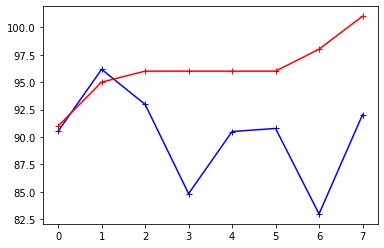

In [5]:
##
## MAIN
##

videoFilename = str(config['ExeConfig']['videoFilename'])  #video to be processed path
modelFilename = str(config['ExeConfig']['modelFilename'])   #model path 

# ROI EXTRACTION
video = extraction_roi(videoFilename)
# Load the model
model, freq_bpm = loadmodel(modelFilename)

frameRate = int(config['DataConfig']['frameRate'])
nameDataset = str(config['ExeConfig']['nameDataset'])
videoGTFilename = str(config['ExeConfig']['videoGTFilename'])
winSizeGT = int(config['DataConfig']['winSizeGT'])
#Data preparation 
x_step = int(config['DataConfig']['Xstep'])
y_step = int(config['DataConfig']['Ystep'])

NB_LAPSE = int(video.numFrames / frameRate)
if(int(config['ExeConfig']['useNbLapse']) == 1):
    NB_LAPSE = int(config['DataConfig']['NbLapse'])
    
GT_BPM  = get_gt(nameDataset, videoGTFilename, winSizeGT, freq_bpm)

# tables for display
Tab_BPM_estimated = []
Tab_BPM_True = []
Tab_Lapse = []

# Second-by-second estimation
for lapse in range(0 ,NB_LAPSE):
    
    startFrame = lapse * frameRate

    end = startFrame + model.input_shape[1]
    if(end > video.numFrames):
        break

    BPM_estimated = make_prediction(video, model, freq_bpm, startFrame, x_step, y_step)
    Tab_BPM_estimated.append(BPM_estimated)
    BPM_True = int(GT_BPM[lapse+int(winSizeGT/2)])
    Tab_BPM_True.append(BPM_True)
    Tab_Lapse.append(lapse)

# Graphic display
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(np.asarray(Tab_Lapse), np.asarray(Tab_BPM_estimated), marker='+', color='blue', label='BPM ESTIMATES')
ax.plot(np.asarray(Tab_Lapse), np.asarray(Tab_BPM_True), marker='+', color='red', label='BPM GT')
plt.show()